In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
import os

### Load BAT catalog GRB tables

In [2]:
grb_all = pd.read_table('../grb_tables/all_grb.csv', sep=',', header=0) # all grbs
grb_conv = grb_all[~grb_all['conversion'].isna()] # all grbs with conversion
grb_redshift = grb_all[~grb_all['redshift'].isna()] # all grbs with redshift
grb_redshift_conv = grb_redshift[~grb_redshift['conversion'].isna()] # all grbs with redshift and conversion

print('all_grb len:', len(grb_all))
print('grb_conv len:', len(grb_conv))
print('grb_redshift len:', len(grb_redshift))
print('grb_redshift_conv len:', len(grb_redshift_conv))

all_grb len: 1527
grb_conv len: 1218
grb_redshift len: 489
grb_redshift_conv len: 470


Configure laff flare run tables.

In [3]:
colnames = ('grb_name', 'flare_num', 't_start', 't_peak', 't_stop', 'par_t_start', 'par_rise', \
            'par_decay', 'par_amp', 'par_t_start_err', 'par_rise_err', 'par_decay_err', 'par_amp_err', \
            'fluence_tot', 'fluence_rise', 'fluence_decay', 'peak_flux', 'peak_flux_err')

dataframe = pd.read_csv('runs/flares.csv', sep=',', names=colnames, index_col=False)


# Clean GRB name.
def clean_name(x):
    x = x.replace(".qdp", "")
    x = (x + 'A') if x[-1] not in ('A', 'B', 'C', 'D') else x
    return str(x)
dataframe['grb_name'] = dataframe['grb_name'].apply(clean_name)

# First integer flare number.
dataframe['flare_num'] = dataframe['flare_num'].apply(lambda x: x+1)

# Obtain redshift.
def obtain_redshift(name):
    try: 
        redshift = float(grb_redshift.loc[grb_redshift[grb_redshift['GRBname'] == name].index, 'redshift'].item())
    except:
        redshift = np.nan
    return redshift
dataframe['redshift'] = dataframe['grb_name'].apply(obtain_redshift)

# Obtain conversion.
def obtain_conversion(name):
    try:
        conversion = float(grb_conv.loc[grb_conv[grb_conv['GRBname'] == name].index, 'conversion'].item())
    except:
        conversion = float(0)
    return conversion
dataframe['conversion'] = dataframe['grb_name'].apply(obtain_conversion)

dataframe['fluence_tot'] = dataframe.apply(lambda row: row.fluence_tot * row.conversion, axis=1)
dataframe['fluence_rise'] = dataframe.apply(lambda row: row.fluence_rise * row.conversion, axis=1)
dataframe['fluence_decay'] = dataframe.apply(lambda row: row.fluence_decay * row.conversion, axis=1)
dataframe['peak_flux'] = dataframe.apply(lambda row: row.peak_flux * row.conversion, axis=1)
dataframe['peak_flux_err'] = dataframe.apply(lambda row: row.peak_flux_err * row.conversion, axis=1)

dataframe['t_rise'] = dataframe.apply(lambda row: row.t_peak - row.t_start, axis=1)
dataframe['t_decay'] = dataframe.apply(lambda row: row.t_stop - row.t_peak, axis=1)

def calculate_wait_time(row):
    if row.flare_num == 1: # If first flare.
        t_wait = row.t_start / (1 + row.redshift)
        return t_wait
    else:
        t_start_prev = float(dataframe.loc[row.name-1, 't_start'])
        t_wait = abs(t_start_prev - float(row.t_start))
        return t_wait
dataframe['t_wait'] = dataframe.apply(calculate_wait_time, axis=1)

dataframe['duration'] = dataframe.apply(lambda row: row.t_stop - row.t_start, axis=1)
dataframe['d_l'] = dataframe.apply(lambda row: cosmo.luminosity_distance(row.redshift).to(u.cm).value if row.redshift != 0 else 0, axis=1)
dataframe['e_iso'] = dataframe.apply(lambda row: 4 * np.pi * (row.d_l**2) * row.fluence_tot / (1 + row.redshift), axis=1) ## cm2 * erg cm^-2 s-1 * s == erg
dataframe['L_p'] = dataframe.apply(lambda row: 4 * np.pi * (row.d_l**2) * row.peak_flux / (1+row.redshift), axis=1) ## cm2 * erg cm-2 s-1 == erg s-1
dataframe['L_iso'] = dataframe.apply(lambda row: (1+row.redshift) * row.e_iso / (row.t_stop - row.t_start), axis=1)

dataframe.to_csv('ongoing.csv', index=False)


to_remove_one = dataframe[((dataframe.grb_name == 'GRB130604A') & (dataframe.flare_num == 2))].index
to_remove_two = dataframe[((dataframe.grb_name == 'GRB121024A') & (dataframe.flare_num == 1))].index

dataframe = dataframe.drop(to_remove_one)
dataframe = dataframe.drop(to_remove_two)



In [4]:
dataframe_redshift = dataframe[dataframe.redshift > 0]

In [5]:
def hist_relation(x_axis: str, log=True):
    if log == False:
        plt.hist(dataframe[x_axis])
    else:
        filtered_axis = dataframe[dataframe[x_axis] != 0][x_axis]
        log_axis = filtered_axis.map(lambda x: np.log10(x))
        plt.hist(log_axis, bins=int(len(log_axis)/20) if len(log_axis) > 20 else 10)
        plt.xlabel('log10('+x_axis+')')
    plt.savefig(f'results/hist-{x_axis}.png')
    plt.show()
    return

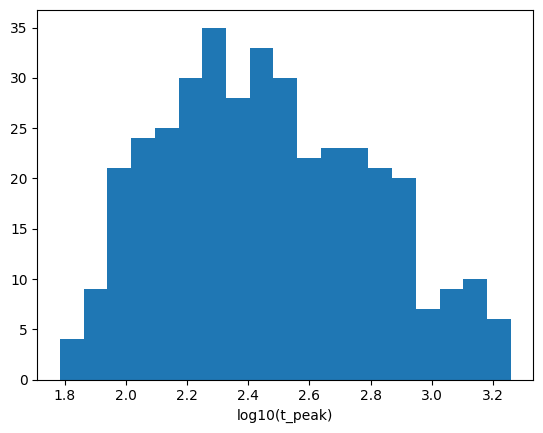

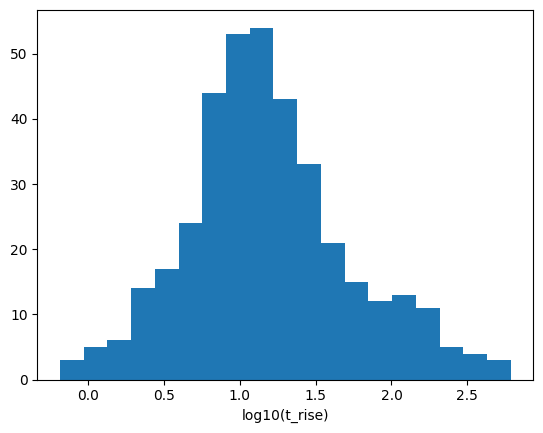

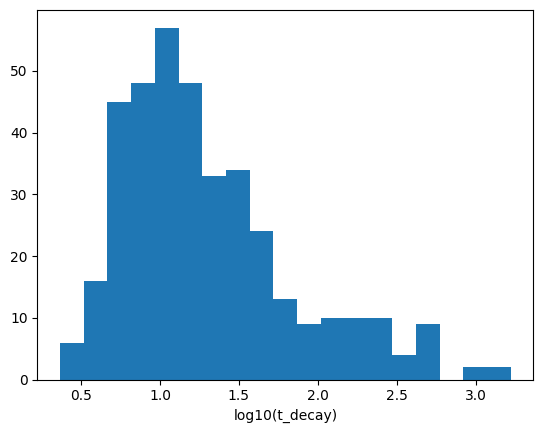

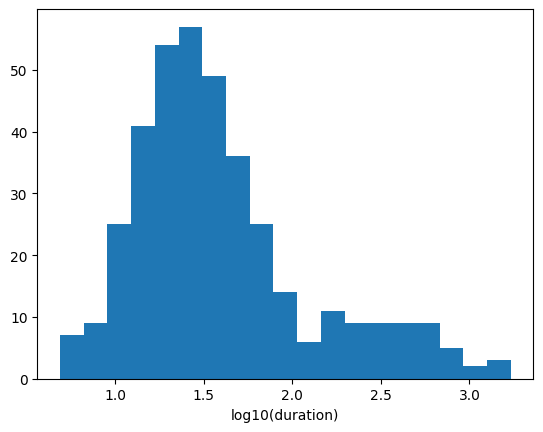

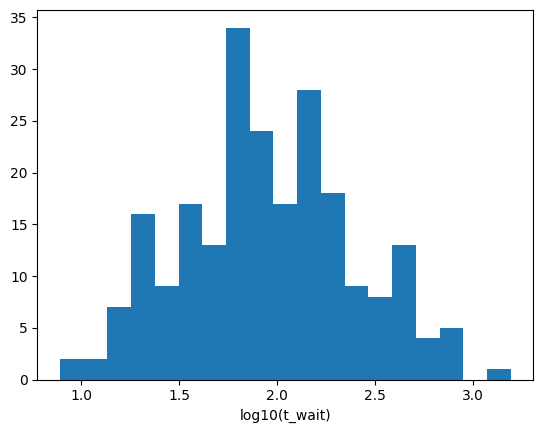

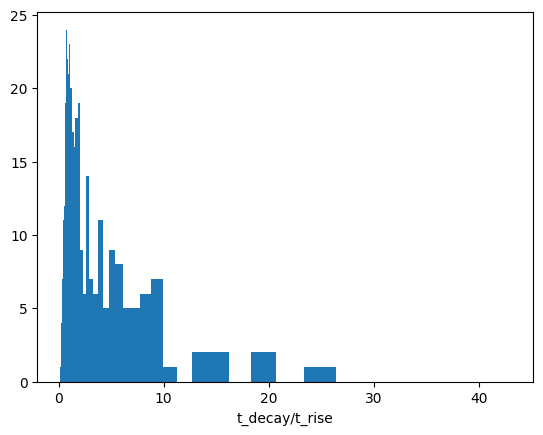

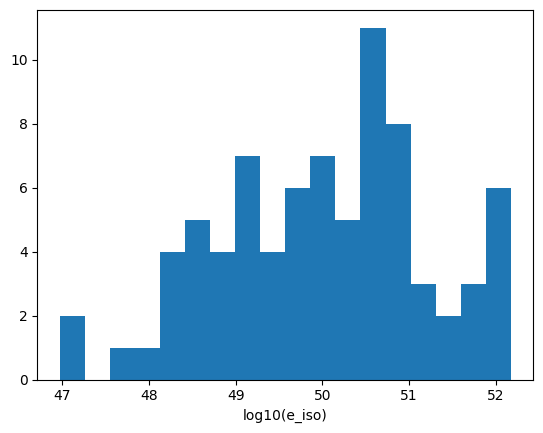

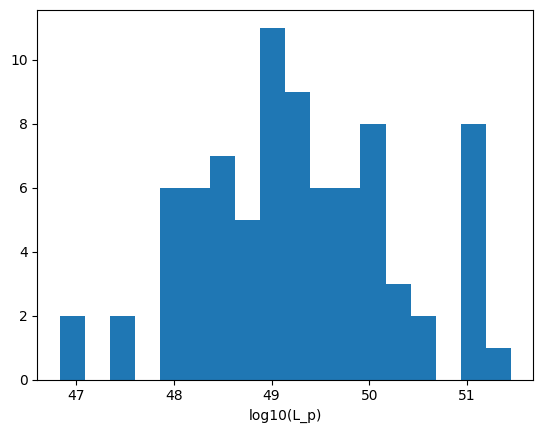

In [6]:
hist_relation('t_peak')
hist_relation('t_rise')
hist_relation('t_decay')
hist_relation('duration')
hist_relation('t_wait')
temp = dataframe['t_decay'] / dataframe['t_rise']
plt.hist(temp, bins=np.logspace(start=np.log10(temp.min()), stop=np.log10(temp.max())))
plt.xlabel('t_decay/t_rise')
plt.show()
hist_relation('e_iso')
hist_relation('L_p')

In [7]:
def plot_relations(x_axis: str, y_axis: str):
    plt.scatter(dataframe[x_axis], dataframe[y_axis], label='All data')
    plt.scatter(dataframe_redshift[x_axis], dataframe_redshift[y_axis], color='r', label='Data with redshift')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.loglog()
    plt.legend()
    plt.savefig(f'results/{x_axis}-{y_axis}.png')
    plt.show()
    return 

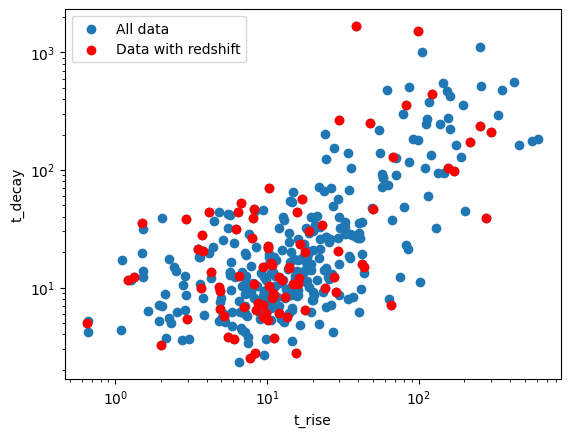

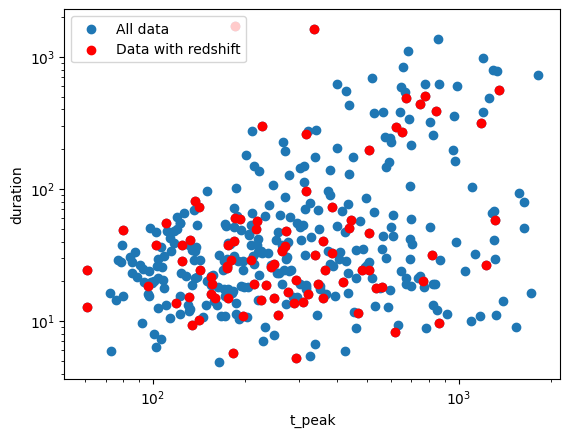

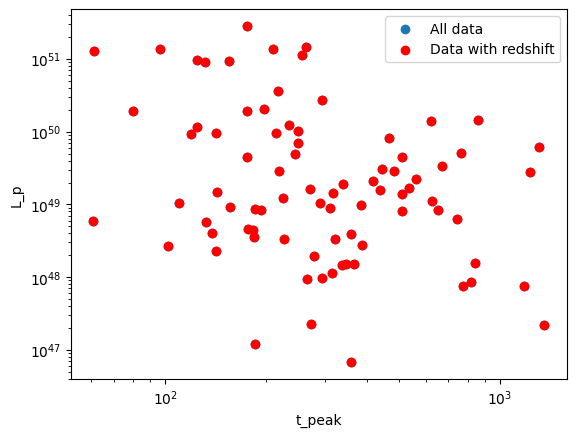

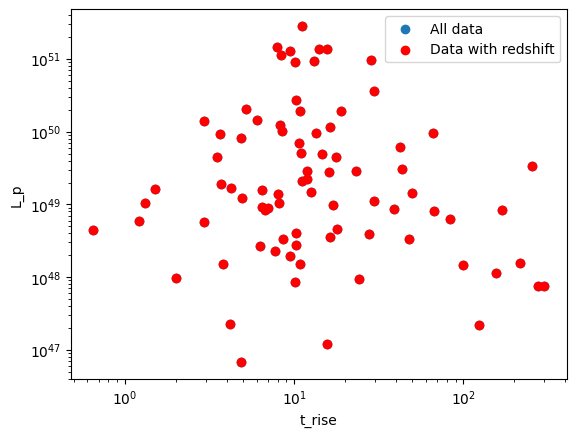

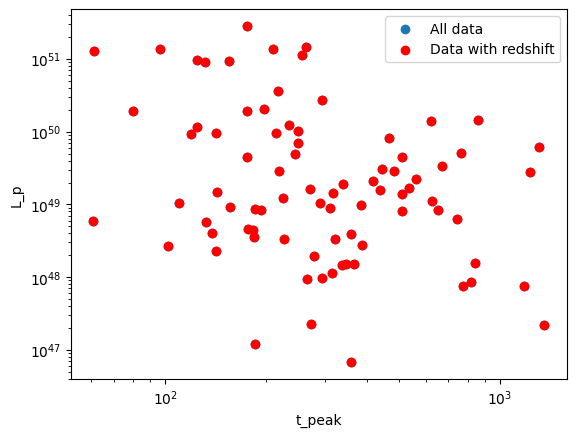

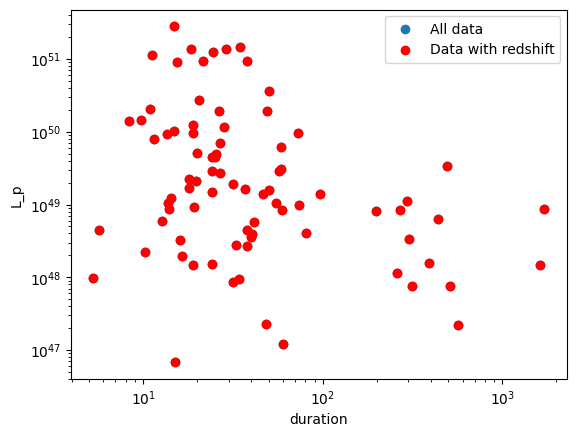

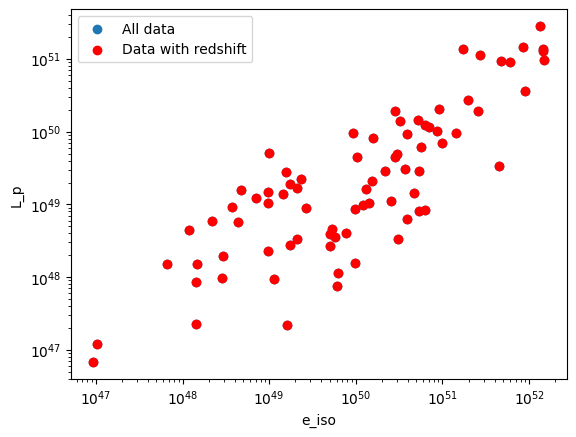

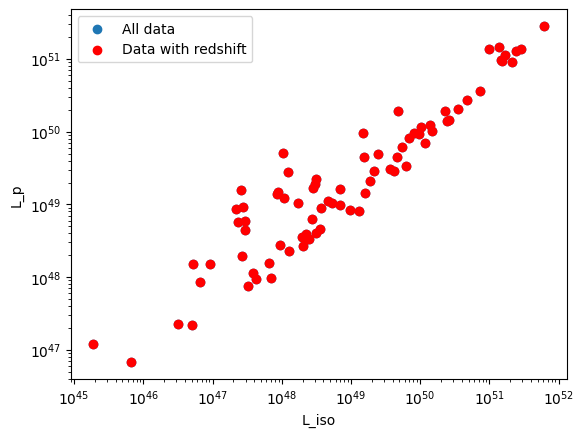

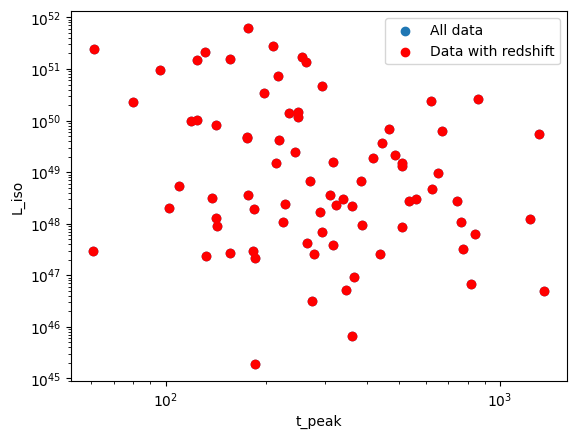

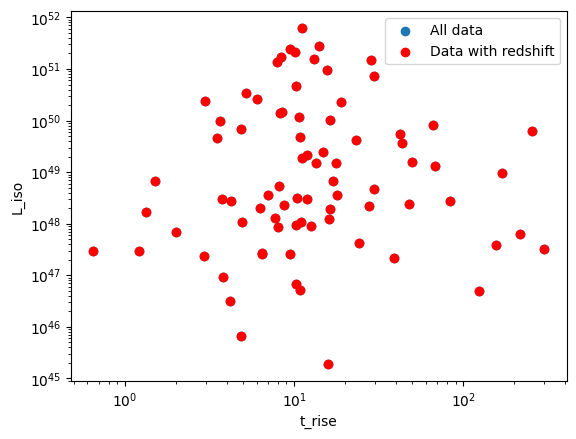

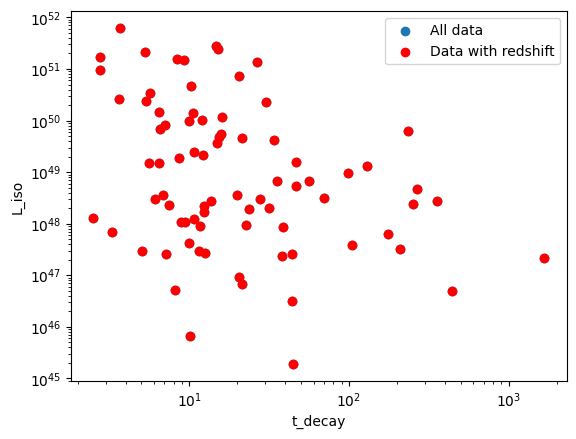

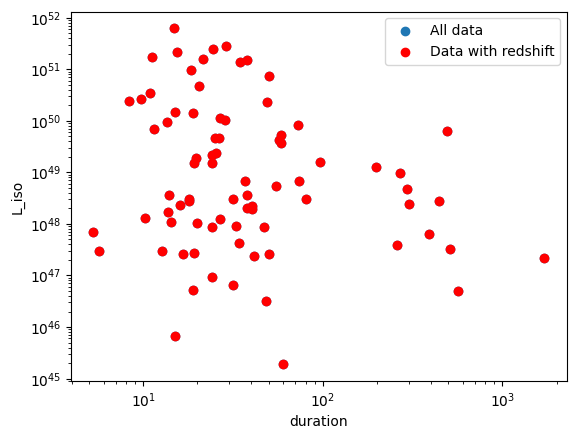

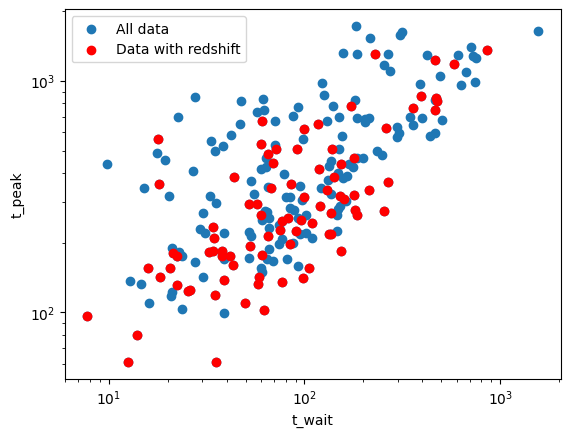

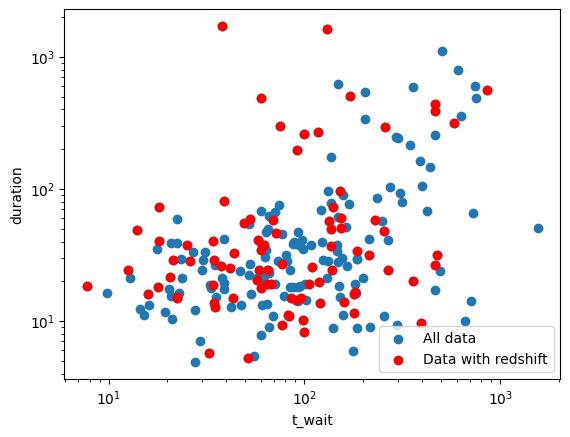

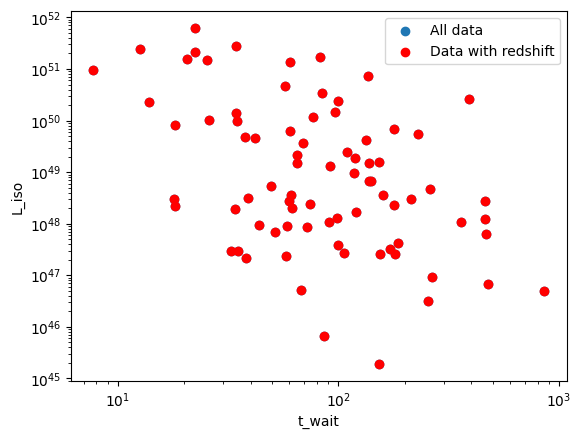

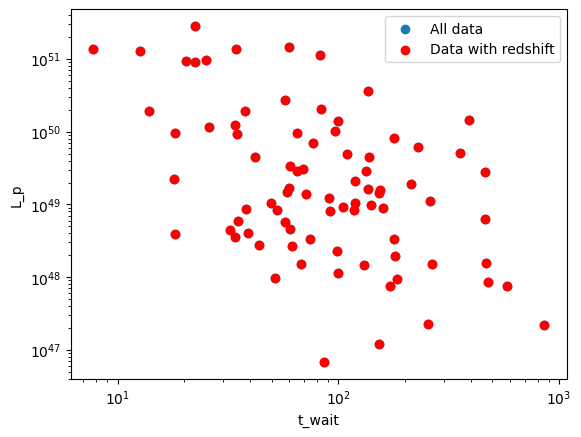

In [8]:
relations = (['t_decay','t_rise'], ['duration','t_peak'], ['L_p','t_peak'], ['L_p','t_rise'], ['L_p','t_peak'], ['L_p', 'duration'], ['L_p', 'e_iso'], ['L_p', 'L_iso'],
        ['L_iso','t_peak'], ['L_iso','t_rise'], ['L_iso','t_decay'], ['L_iso','duration'], ['t_peak','t_wait'], ['duration','t_wait'], ['L_iso', 't_wait'],
        ['L_p', 't_wait'])

for y, x in relations:
    plot_relations(x, y)
    